In [1]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

In [2]:
def grad_log_prior(x):
    # Means in the GMM
    means = np.array([
        [4, 0], [0, 4], [-4, 0], [0, -4], 
        [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]
    ])
    sigma = np.sqrt(0.1)

    # Precompute constants for Gaussian multivariate normal PDFs
    cov = (sigma**2) * np.eye(2)
    gaussian_pdfs = np.array([stats.multivariate_normal.pdf(x, mean=mean, cov=cov) for mean in means])

    # Compute gradients of each of the mixture elements
    grad_components = np.array([x - mean for mean in means])
    weighted_grads = gaussian_pdfs[:, None] * grad_components

    # Sum over all Gaussians and normalize by the total probability
    epsilon = 1e-12
    sum_priors = np.sum(gaussian_pdfs)
    grad = (-1 / (sigma**2)) * np.sum(weighted_grads, axis=0) / (sum_priors + epsilon)

    grad_x, grad_y = grad
    return grad_x, grad_y
    # return np.array([grad_x, grad_y])

# Gradient of the log-posterior density p(x|y)
def grad_log_posterior(x):
    sigma = np.sqrt(2)
    y = 0  # Observation

    # Gradient of the log-likelihood
    grad_log_likelihood_xy = (-1 / (sigma**2)) * (np.sum(x) - y)
    grad_x, grad_y = grad_log_prior(x)
    return grad_x, grad_y
    return np.array(grad_x + grad_log_likelihood_xy, grad_y + grad_log_likelihood_xy)
    
def gmm_langevin_proposal(v, m, step_size):
    g1, g2 = grad_log_posterior(v)
    g = np.array([g1, g2])
    s = step_size
    return np.random.multivariate_normal(mean=v + (s * g), cov=2 * s * np.identity(2))

def gmm_langevin_pdf(v1, v, step_size):
    # probability of going from x -> x1 given langevin proposals
    g1, g2 = grad_log_posterior(v)
    g = np.array([g1, g2])
    s = step_size
    return stats.multivariate_normal.pdf(v1, mean=v + (s * g), cov=2 * s * np.identity(2))

def prior_pdf(x, m, s0_sq):
    return np.mean([stats.multivariate_normal.pdf(x, mean=mu, cov=s0_sq * np.identity(2)) for mu in m])

def likelihood_pdf(y, x, s_sq):
    return stats.norm.pdf(y, loc=np.sum(x), scale=s_sq)

def adjusted_posterior(x, y, step):
    g_y_d1, g_y_d2 = grad_log_posterior(y)

    q_dim_1 = stats.norm.pdf(x[0], loc=y[0] + step * g_y_d1, scale=np.sqrt(2 * step))
    q_dim_2 = stats.norm.pdf(x[1], loc=y[1] + step * g_y_d2, scale=np.sqrt(2 * step))
    
    return q_dim_1 * q_dim_2
    
def mala_mh_posterior(m, s_sq, s0_sq, step_size, N=100000, epsilon=10e-9):
    v = np.array([0, 0], dtype=np.float64)
    
    v_samples = []
    accepted_samples = 0
    
    progress_bar = tqdm(total=N, leave=True)
    while len(v_samples) < N:
        v1 = gmm_langevin_proposal(v, m, step_size)
        y = 0
        
        original = prior_pdf(v, m, s0_sq) * likelihood_pdf(y, v, s_sq)
        proposal = prior_pdf(v1, m, s0_sq) * likelihood_pdf(y, v1, s_sq)
        
        a = min(
            1,
            (proposal * adjusted_posterior(v, v1, step_size)) /
            (original * adjusted_posterior(v1, v, step_size))
        )
        

        if np.random.uniform() < a:
            v = v1
            accepted_samples += 1

        v_samples.append(v)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")

    v_samples = np.array(v_samples)
    return v_samples[:, 0], v_samples[:, 1]

In [5]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2
y = 0

mala_x, mala_y = mala_mh_posterior(m, s_sq, s0_sq, step_size=0.18, N=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

Acceptance rate: 0.35


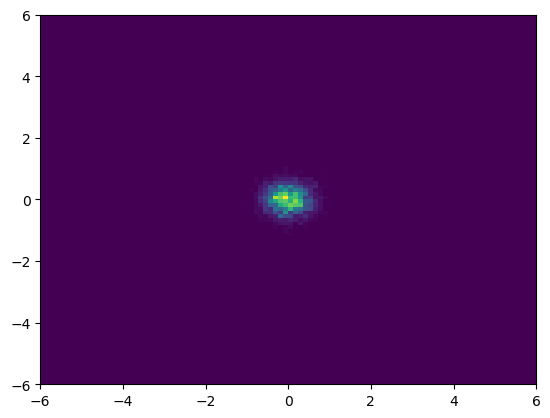

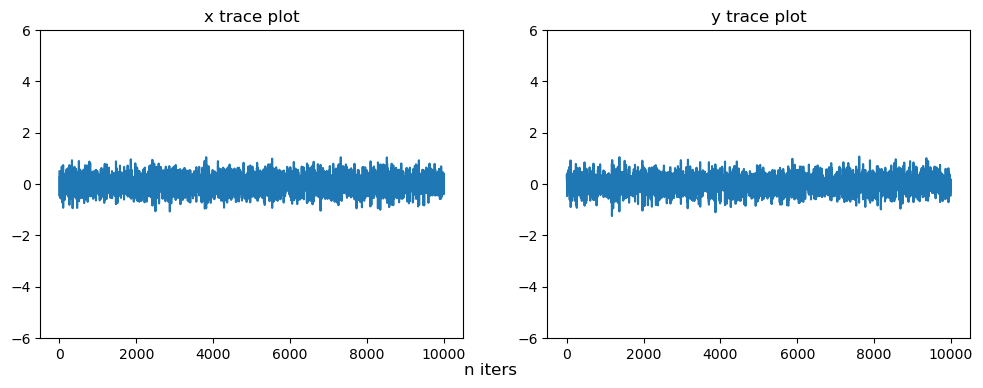

In [6]:
burnin = 10000
plt.hist2d(mala_x[burnin:], mala_y[burnin:], bins=100, cmap='viridis', range=[[-6, 6], [-6, 6]])
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(mala_x[burnin:])
ax[0].set_ylim((-6, 6))
ax[0].set_title('x trace plot')
ax[1].plot(mala_y[burnin:])
ax[1].set_ylim((-6, 6))
ax[1].set_title('y trace plot')
fig.supxlabel('n iters')
plt.show()

In [23]:
# Define the log-gradient for prior
def grad_log_prior_1(x, mus, sigma2=0.1):
    """Return the value of the grad of log-prior at x1, x2 given mus and sigma"""
    
    # Compute differences and squared distances
    diffs = x - mus  # (9, 2)
    sq_dists = np.sum(diffs**2, axis=1)  # (9,)
    # Compute weights = exp(-||x - mu_i||² / (2 * sigma²))
    weights = np.exp(-sq_dists / (2 * sigma2))  # Shape: (9,)
    # Weighted sum of (x - mu_i)
    weighted_sum = np.sum(diffs * weights[:, np.newaxis], axis=0)  # Shape: (2,)
    # Denominator = sum of weights
    denom = np.sum(weights)
    # Gradient of log-prior
    grad = -(1.0 / sigma2) * (weighted_sum / denom)
    
    return grad

def grad_log_prior_2(x):
    # Means in the GMM
    means = np.array([
        [4, 0], [0, 4], [-4, 0], [0, -4], 
        [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]
    ])
    sigma = np.sqrt(0.1)

    # Precompute constants for Gaussian multivariate normal PDFs
    cov = (sigma**2) * np.eye(2)
    gaussian_pdfs = np.array([stats.multivariate_normal.pdf(x, mean=mean, cov=cov) for mean in means])

    # Compute gradients of each of the mixture elements
    grad_components = np.array([x - mean for mean in means])
    weighted_grads = gaussian_pdfs[:, None] * grad_components

    # Sum over all Gaussians and normalize by the total probability
    epsilon = 0
    sum_priors = np.sum(gaussian_pdfs)
    grad = (-1 / (sigma**2)) * np.sum(weighted_grads, axis=0) / (sum_priors + epsilon)

    return grad

def grad_log_prior_3(x, m, s0_sq=0.1):
    w = np.array([np.exp(np.sum((x - mu)**2) / (-2*s0_sq)) for mu in m])
    return -np.sum(w[:, None] * (x - m), axis=0) / (s0_sq * np.sum(w))


mm = np.array([
        [4, 0], [0, 4], [-4, 0], [0, -4], 
        [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]
    ])
x = np.array([2.5, -1.4])

[grad_log_prior_1(x, mm), grad_log_prior_2(x), grad_log_prior_3(x, mm)]

[array([14.99999992, 14.        ]),
 array([14.99999992, 14.        ]),
 array([14.99999992, 14.        ])]

In [33]:
def grad_log_likelihood_1(y, x1, x2, sigma2=2):
    """Return the value of grad of log-prior at y given x1, x2 and sigma2."""
    print( (y - x1 - x2)/sigma2)
    return (y - x1 - x2)/sigma2

In [47]:
def grad_log_posterior_1(x, y, mus):
    """Return the value of the grad of log-posterior at x1, x2 using the sum of \
        the previous 2 functions as input y and mus. """
    return grad_log_prior_1(x, mus) + grad_log_likelihood_1(y, x[0], x[1])

# Gradient of the log-posterior density p(x|y)
def grad_log_posterior_2(x):
    sigma = np.sqrt(2)
    y = 0  # Observation

    # Gradient of the log-likelihood
    grad_log_likelihood_xy = (-1 / (sigma**2)) * (np.sum(x) - y)
    grad_x, grad_y = grad_log_prior_2(x)
    return np.array([grad_x + grad_log_likelihood_xy, grad_y + grad_log_likelihood_xy])

def grad_log_posterior_3(x, m, s0_sq=0.1, s_sq=2, H=np.array([1, 1]), y=0):
    grad_lp = grad_log_prior_3(x, m, s0_sq)
    grad_log_likelihood = ((y - H.dot(x)) / s_sq) * H # MINUS ON THE s_sq
    print(grad_log_likelihood)
    return grad_lp + grad_log_likelihood

[grad_log_posterior_1(x, 0, mm), grad_log_posterior_2(x), grad_log_posterior_3(x, mm)]

-0.55
[-0.55 -0.55]


[array([14.44999992, 13.45      ]),
 array([14.44999992, 13.45      ]),
 array([14.44999992, 13.45      ])]

In [61]:
# Define the likelihood function
def likelihood_1(y, x, sigma2=2):
    """Return the likelihood of observing y given x1 and x2 with variance sigma."""
    return np.exp(-((y - x[0] - x[1])**2)/(2 * sigma2)) / np.sqrt(2 * np.pi * sigma2)
    
def likelihood_3(y, x, s_sq=2):
    return stats.norm.pdf(y, loc=np.sum(x), scale=np.sqrt(s_sq))

x = np.array([2.5, -1.4])

[likelihood_1(y, x), likelihood_3(y, x)]

[0.20845916182286442, 0.2084591618228644]

In [69]:
# Define the GMM prior
def prior_1(x1, x2, mus, sigma2=0.1):
    """Calculate the GMM prior probability for given x1, x2 using mus and sigma."""

    # Initialise prob 
    prob = 0.

    # Calculate each GMM prior
    for mu1, mu2 in mus:
        # print(mu1, mu2)
        # Find the probability for x1
        p1 = np.exp(-((x1 - mu1) ** 2)/(2 * sigma2))
        # Find the probabiblity for x2
        p2 = np.exp(-((x2 - mu2) ** 2)/(2 * sigma2))

        prob += (p1 * p2) / (2 * np.pi * sigma2)
    
    return prob/9

def prior_3(x, m, s0_sq=0.1):
    return np.mean([stats.multivariate_normal.pdf(x, mean=mu, cov=s0_sq * np.identity(2)) for mu in m])

[prior_1(x[0], x[1], mm), prior_3(x, mm)]

[1.2754950544982775e-10, 1.2754950544982736e-10]